In [1]:

import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import pyarrow.parquet as pq

from numba import jit
from tqdm import tqdm
import gc

import keras
import keras.backend as K
from keras.layers import LSTM,Dropout,Dense,TimeDistributed,Conv1D,MaxPooling1D,Flatten
from keras.models import Sequential
from keras.layers import BatchNormalization
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
import tensorflow as tf

from IPython.display import display, clear_output

from sklearn.metrics import matthews_corrcoef
from numpy.fft import *
from scipy import fftpack
from sklearn.model_selection import train_test_split

# import seaborn as sns
# sns.set_style("whitegrid")

import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!cp "/content/drive/My Drive/DigitalData.txt" "DigitalData.txt"

In [0]:
!cp "/content/drive/My Drive/DigitalData.txt" "AnalogData.txt"

In [0]:
!pwd

/content


# New Section

In [5]:
df1=pd.read_csv("AnalogData.txt")
df2 = pd.read_csv('DigitalData.txt')
"""from google.colab import files
uploaded = files.upload()
import io
df1 = pd.read_csv(io.BytesIO(uploaded['AnalogData.txt']))
df2 = pd.read_csv(io.BytesIO(uploaded['DigitalData.txt']))"""


"from google.colab import files\nuploaded = files.upload()\nimport io\ndf1 = pd.read_csv(io.BytesIO(uploaded['AnalogData.txt']))\ndf2 = pd.read_csv(io.BytesIO(uploaded['DigitalData.txt']))"

In [0]:
df1.rename(columns = {'Tag1':'Voltage','Tag2':'Current','Tag3':'KiloWatt','Tag4':'Cumulative KiloWatt Hrs','Tag5':'Burn Hrs','Tag6':'Dimming','Tag7':'Power Factor','Tag8':'Lamp Steady Current','Tag9':'Mode','Tag10':'Temperature'}, inplace = True) 

In [0]:
df3=df1.iloc[: ,0:12]

In [0]:
df2.rename(columns = {'Tag1':'Lamp Status','Tag2':'Photocell Status','Tag3':'Voltage Under Over','Tag4':'Lamp','Tag5':'Photocell Oscillation','Tag6':'Photocell Feedback','Tag7':'Lamp Cyclic','Tag8':'Communication','Tag9':'Driver','Tag10':'Abnormal Lamp Condit','Tag11':'RTC Status','Tag12':'Event Over Flow','Tag13':'EM Fault','Tag14':'Relay Weld','Tag15':'Tilt','Tag16':'Day Burning','Tag17':'Pole Fault','Tag18':'Photocell Fault'}, inplace = True)

In [0]:
df4=df2.iloc[:,0:20]

In [0]:
df4=df4.drop(["DateTimeField","RTUNumber"],axis=1)

In [0]:
df=pd.concat([df3, df4],axis=1)

In [0]:
DF=df[108:]

In [13]:
DF.head()


,DateTimeField,RTUNumber,Voltage,Current,KiloWatt,Cumulative KiloWatt Hrs,Burn Hrs,Dimming,Power Factor,Lamp Steady Current,Mode,Temperature,Lamp Status,Photocell Status,Voltage Under Over,Lamp,Photocell Oscillation,Photocell Feedback,Lamp Cyclic,Communication,Driver,Abnormal Lamp Condit,RTC Status,Event Over Flow,EM Fault,Relay Weld,Tilt,Day Burning,Pole Fault,Photocell Fault
108,2019-06-24 20:44:38,7001,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
109,2019-06-25 06:51:25,7001,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1
110,2019-06-25 09:26:22,55653,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0
111,2019-06-25 09:31:25,55653,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,1,0
112,2019-06-25 20:46:30,7001,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [14]:
DF.isnull().sum()

DateTimeField              0
RTUNumber                  0
Voltage                    0
Current                    0
KiloWatt                   0
Cumulative KiloWatt Hrs    0
Burn Hrs                   0
Dimming                    0
Power Factor               0
Lamp Steady Current        0
Mode                       0
Temperature                0
Lamp Status                0
Photocell Status           0
Voltage Under Over         0
Lamp                       0
Photocell Oscillation      0
Photocell Feedback         0
Lamp Cyclic                0
Communication              0
Driver                     0
Abnormal Lamp Condit       0
RTC Status                 0
Event Over Flow            0
EM Fault                   0
Relay Weld                 0
Tilt                       0
Day Burning                0
Pole Fault                 0
Photocell Fault            0
dtype: int64

In [0]:
D=DF.dropna()

In [16]:
D.isna().sum()

DateTimeField              0
RTUNumber                  0
Voltage                    0
Current                    0
KiloWatt                   0
Cumulative KiloWatt Hrs    0
Burn Hrs                   0
Dimming                    0
Power Factor               0
Lamp Steady Current        0
Mode                       0
Temperature                0
Lamp Status                0
Photocell Status           0
Voltage Under Over         0
Lamp                       0
Photocell Oscillation      0
Photocell Feedback         0
Lamp Cyclic                0
Communication              0
Driver                     0
Abnormal Lamp Condit       0
RTC Status                 0
Event Over Flow            0
EM Fault                   0
Relay Weld                 0
Tilt                       0
Day Burning                0
Pole Fault                 0
Photocell Fault            0
dtype: int64

In [17]:
D.head()

,DateTimeField,RTUNumber,Voltage,Current,KiloWatt,Cumulative KiloWatt Hrs,Burn Hrs,Dimming,Power Factor,Lamp Steady Current,Mode,Temperature,Lamp Status,Photocell Status,Voltage Under Over,Lamp,Photocell Oscillation,Photocell Feedback,Lamp Cyclic,Communication,Driver,Abnormal Lamp Condit,RTC Status,Event Over Flow,EM Fault,Relay Weld,Tilt,Day Burning,Pole Fault,Photocell Fault
108,2019-06-24 20:44:38,7001,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
109,2019-06-25 06:51:25,7001,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1
110,2019-06-25 09:26:22,55653,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0
111,2019-06-25 09:31:25,55653,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,1,0
112,2019-06-25 20:46:30,7001,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [0]:
d1=D.drop(['RTUNumber','Driver','DateTimeField'],axis=1)

In [0]:
x=D.drop(['RTUNumber','Driver','DateTimeField'],axis=1)
y=D.Driver

In [20]:
x.head()

,Voltage,Current,KiloWatt,Cumulative KiloWatt Hrs,Burn Hrs,Dimming,Power Factor,Lamp Steady Current,Mode,Temperature,Lamp Status,Photocell Status,Voltage Under Over,Lamp,Photocell Oscillation,Photocell Feedback,Lamp Cyclic,Communication,Abnormal Lamp Condit,RTC Status,Event Over Flow,EM Fault,Relay Weld,Tilt,Day Burning,Pole Fault,Photocell Fault
108,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
109,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1
110,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0
111,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,1,1,0
112,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


In [21]:
D['Driver'].value_counts()


0    1744691
1       8596
Name: Driver, dtype: int64

def feature_extractor(x, n_part=1000):
    length = len(x)
    pool = np.int32(np.ceil(length/n_part))
    output = np.zeros((n_part,))
    for j, i in enumerate(range(0,length, pool)):
        if i+pool < length:
            k = x[i:i+pool]
        else:
            k = x[i:]
        output[j] = np.max(k, axis=0) - np.min(k, axis=0)
    return output

In [0]:
from sklearn.preprocessing import StandardScaler,MinMaxScaler
ss=MinMaxScaler()
x1=ss.fit_transform(x)

In [0]:
x_train,x_test,y_train,y_test=train_test_split(x1,y,test_size=0.2)

In [24]:
x_train[0]

array([1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 1.])

In [0]:
y_train= np.array(y_train)

In [26]:
x_train_exp_dim = np.expand_dims(x_train, axis=2)
x_train_exp_dim.shape

(1402629, 27, 1)

In [27]:
#X_train = np.array(x_train).reshape(-1,x_train.shape[0])
x_train.shape

(1402629, 27)

In [28]:
model = Sequential()
model.add(Conv1D(32,(3), activation='relu',input_shape=(27,1)))
#model.add(Conv1D(filters=64, kernel_size=2, activation='relu',input_shape=(2)))
# model.add(Dropout(0.2))
# model.add(Flatten(input_shape=(1,1)))
model.add(Flatten())

# Add LSTM model
#model.add(LSTM(100))
model.add(BatchNormalization())
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',  optimizer='adam',metrics=['accuracy'])





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [29]:

%%time
model.fit(x_train_exp_dim, y_train, epochs=5,validation_split=0.5, batch_size=500, verbose=True)




Train on 701314 samples, validate on 701315 samples
Epoch 1/5





701314/701314 [==============================] - 25s 36us/step - loss: 0.0029 - acc: 0.9997 - val_loss: 2.6650e-05 - val_acc: 1.0000
Epoch 2/5
701314/701314 [==============================] - 12s 17us/step - loss: 8.7806e-06 - acc: 1.0000 - val_loss: 1.6647e-07 - val_acc: 1.0000
Epoch 3/5
701314/701314 [==============================] - 12s 17us/step - loss: 3.2808e-06 - acc: 1.0000 - val_loss: 1.4297e-07 - val_acc: 1.0000
Epoch 4/5
701314/701314 [==============================] - 12s 17us/step - loss: 9.7317e-07 - acc: 1.0000 - val_loss: 1.0051e-07 - val_acc: 1.0000
Epoch 5/5
701314/701314 [==============================] - 12s 17us/step - loss: 4.1720e-07 - acc: 1.0000 - val_loss: 1.0012e-07 - val_acc: 1.0000
CPU times: user 1min 29s, sys: 11 s, total: 1min 40s
Wall time: 1min 13s


In [0]:
x_test_exp_dim = np.expand_dims(x_test, axis=2)
x_test_exp_dim.shape
y_pred=model.predict(x_test_exp_dim)

In [31]:
y_pred.shape

(350658, 1)

In [32]:

y_test_exp_dim = np.expand_dims(y_test, axis=1)
y_test_exp_dim.shape

(350658, 1)

In [33]:
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score 

results = confusion_matrix(y_pred.round(),y_test_exp_dim)
accuracy_score(y_test_exp_dim,y_pred.round())

1.0

In [34]:
print(results)

[[348934      0]
 [     0   1724]]


In [35]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 25, 32)            128       
_________________________________________________________________
flatten_1 (Flatten)          (None, 800)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 800)               3200      
_________________________________________________________________
dense_1 (Dense)              (None, 50)                40050     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total params: 43,429
Trainable params: 41,829
Non-trainable params: 1,600
______________________________________________

In [36]:
submission = pd.DataFrame({"Y_act":y_test,
                           "Y_pred":b,
                    
      
    })
submission.to_csv('/content/drive/My Drive/k.csv')

NameError: ignored

In [0]:
y_test.shape

(350658,)

In [0]:
y_pred.shape

(350658, 1)

In [0]:
 b = y_pred.ravel()

In [0]:
import itertools

In [0]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    #else:
    #    print('Confusion matrix, without normalization')
    #print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

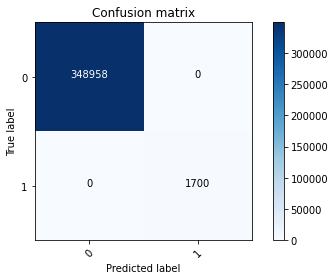

In [0]:
plot_confusion_matrix(results,[0,1])